# Excercise 6 - Generate a Dihedral Potential Curve 
Conformational analysis is the study of the change in molecular energy with respect to rotation of a molecule's single bonds. Oftentimes such rotations are dihedral, meaning that they change the angle between two intersecting planes formed by two sets of three atoms, where two atoms are shared in a common bond. Here, we'll explore the change in molecular energy of ethanol with respect to the change in C-C-O-H dihedral angle using Python and PySCF. We will identify the energetic maximum, as well as two degenerate minima and the global minimum dihedral angle.  


First, we will install PySCF:

In [0]:
!pip install pyscf


     |████████████████████████████████| 26.0MB 1.3MB/s 


And import the relevant dependencies:

In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import pyscf
from pyscf import gto, scf

Read through the following six functions, which we will use to read in the ethanol molecular file, manipulate its bond geometries, and generate input files for the PySCF calculations.

In [0]:
def get_mol(filename):
	# read in atomic labels and coordinates from the molecular input file
	lines = open(filename, 'r').readlines()

	labels = []
	coords = []
	# loop over each in the input file
	for i, line in enumerate(lines):
	#look at the input file, do these line numbers match?
		if i == 0: numAtoms = line
		if i == 1: continue
	#break the coordinates into three list indices for x, y, and z
		if i > 1:
			tokens = line.split()
			labels.append(tokens[0])
			coords.append([ float(tokens[1]), float(tokens[2]), float(tokens[3]) ])

	return numAtoms, labels, coords

In [0]:
def center_atom(atom_ind, coords):
	# move chosen atom, given by atom_ind, to origin
	
	center = coords[atom_ind]
	#all coordinates are relative to eachother, so by subtracting all coordinate values by the chosen atom coordinates, we can recenter the molecule
	for i in range(len(coords)):
		coords[i] = [ coords[i][0] - center[0], coords[i][1] - center[1], coords[i][2] - center[2] ]

	return coords

In [0]:
def rotate_bond(arm_ind, pivot_ind, ref_ind, theta, coords):
    #rotate the bond formed by the arm and pivot atoms by theta degrees around the bond axis specified by the reference and pivot atoms
    #note that the pivot atom has to be at origin in order for the rotation to work correctly

    #we can apply continuous rotations without altering the original coordinates
    coords_new = np.copy(coords)
    arm = coords_new[arm_ind]
    pivot = coords_new[pivot_ind]
    ref = coords_new[ref_ind]

    #define the vector to be rotated, and the axis around which the rotation occurs
    vec = np.array([ arm[0] - pivot[0], arm[1] - pivot[1], arm[2] - pivot[2] ])
    axis = np.array([ pivot[0] - ref[0], pivot[1] - ref[1], pivot[2] - ref[2] ])

    #pass the vector and axis to the rotation matrix function, which returns a rotation matrix. 
    #The new rotated arm atom coordinates are the dot product of the rotation matrix and the old arm atom coordinates 
    #The function returns the updated molecular coordinates
    coords_new[arm_ind] = np.dot( rotation_matrix((axis), theta), [ arm[0], arm[1], arm[2] ] )
    return coords_new

In [0]:
def get_dihedral(pivot, ref, arm, leg):
    #returns the dihedral angle formed by arm atom with respect to the plane formed by the leg, reference, and pivot atoms
    vec = np.array([ arm[0] - pivot[0], arm[1] - pivot[1], arm[2] - pivot[2] ])
    axis = np.array([ pivot[0] - ref[0], pivot[1] - ref[1], pivot[2] - ref[2] ])
    #the anchor vector is the bond between the reference and leg atom
    anchor = np.array([ ref[0] - leg[0], ref[1] - leg[1], ref[2] - leg[2] ])
    #generate a vector orthogonal to the plane formed by the axis and anchor vectors
    normal_anchor = np.cross(axis, anchor) 
    #generate a vector orthogonal to the plane formed by the axis and arm vectors
    normal_vec = np.cross(vec,axis)
    #find the angle between the normal_anchor vector and the normal_arm vector
    theta_norm = np.arccos( np.dot(normal_vec, normal_anchor) / (np.linalg.norm(normal_anchor) * np.linalg.norm(normal_vec)) )
    #the angle between two vectors normal to two planes equals the angle between the two planes
    return theta_norm

In [0]:
def rotation_matrix(axis, theta):
	#return a rotation matrix encoding a theta degree rotation around the given axis
	axis = np.asarray(axis)
	axis = axis / np.sqrt(np.dot(axis, axis))
	a = np.cos(theta / 2.0)

	b, c, d = -axis * np.sin(theta / 2.0)
	aa, bb, cc, dd = a * a, b * b, c * c, d * d
	bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d

	return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
									 [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
									 [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

In [0]:
def coords_to_input(coords, labels):
  #convert molecular coordinates and labels into the pyscf input format
  input_list = []
  for c_index, coord in enumerate(coords):
    coord_input = coord.tolist()
    coord_input.insert(0, labels[c_index])
    input_list.append(coord_input)
  return input_list

First, generate the ethanol molecule by reading in the ethanol xyz file placed in the content folder.

In [0]:
natoms, labels, coords = get_mol('/content/ethanol.xyz')


Try printing the number of atoms in ethanol, as well as their corresponding atomic labels and coordinates.

In [0]:
## Print out natoms, labels, and coords


Run this cell to generate a 3-D plot of ethanol, where the atoms comprising the dihedral torsion are labeled by their corresponding atomic indices, and are named with reference to the rotate_bond and get_dihedral functions. 

We will be rotating the alchoholic hydrogen, or 'arm' (#8) around the #4-#7 bond axis formed by the 'pivot' oxygen and 'reference' carbon, which will change the #1-#4-#7-#8 dihedral angle.  

Feel free to alter the view angles on the plot, as highlighted below.



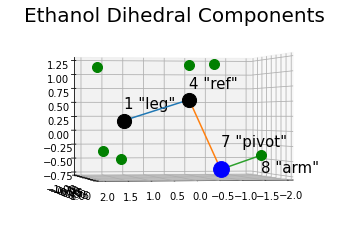

In [0]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot([coords[1][0], coords[4][0]], [coords[1][1], coords[4][1]],[coords[1][2], coords[4][2]])
ax.plot([coords[7][0], coords[4][0]], [coords[7][1], coords[4][1]],[coords[7][2], coords[4][2]])
ax.plot([coords[7][0], coords[8][0]], [coords[7][1], coords[8][1]],[coords[7][2], coords[8][2]])
for c_index, coord in enumerate(coords):
  if c_index == 8:
    ax.text(coord[0], coord[1], coord[2]-0.3,  '%s' % (str(c_index))+' "arm"', size=15, zorder=1, color='k') 
  if c_index == 7:
    ax.text(coord[0], coord[1], coord[2]+0.4,  '%s' % (str(c_index))+' "pivot"', size=15, zorder=1, color='k') 
  if c_index == 4:
    ax.text(coord[0], coord[1], coord[2]+0.2,  '%s' % (str(c_index))+' "ref"', size=15, zorder=1, color='k') 
  if c_index == 1:
    ax.text(coord[0], coord[1], coord[2]+0.2,  '%s' % (str(c_index))+' "leg"', size=15, zorder=1, color='k') 
    
  if labels[c_index] == 'H':
    ax.scatter(coord[0], coord[1], coord[2], color = 'green', s=100)
  if labels[c_index] == 'C':
    ax.scatter(coord[0], coord[1], coord[2], color = 'black', s=200)
  if labels[c_index] == 'O':
    ax.scatter(coord[0], coord[1], coord[2], color = 'blue', s=250)
# You can change the elevation and azimuth angles to view the alchohol bond from different perspectives.    
###
  ax.view_init(elev=0., azim=80)
###

ax.set_title("Ethanol Dihedral Components", size=20)
fig.show()

The rotate_bond function requires that the pivot point be set at [0,0,0]. Therefore, we first recenter the ethanol coordinates with respect to the oxygen:



In [0]:
coords = center_atom(7, coords)

We then pass in the 'arm', 'pivot', and 'reference' atom indices into the rotate_bond function, along with the molecular coordinates and bond rotation angle. The function returns the updated set of coordinates.

In [0]:
coords_new = rotate_bond(8, 7, 4, np.pi/3, coords)
#Experiment by passing in various rotation angles

The dihedral angle can be generated at any point by passing in the coordinates of the 'pivot', 'reference', 'arm', and 'leg' atoms to the get_dihedral function. Ensure that the coordinates passed in are the updated coordinates.

In [0]:
theta_dihedral = get_dihedral(coords_new[7], coords_new[4], coords_new[8], coords_new[1])

# Print various dihedral angles for different rotation angles, and note the relationship

1.0471975511965976
-1.0445434806179872


In this case, we note that the rotation angle and dihedral angle differ by $\pi$ radians, as the initial angle in the xyz file is at the dihedral energy minimum. One can therefore simply subtract the rotation angle by $\pi$ radians to achieve the dihedral angle.

Run the cell below to generate a 3-D plot of the updated ethanol molecule, and check to see the rotated O-H bond. 

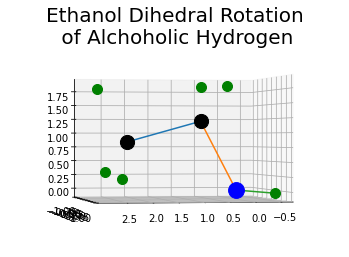

In [0]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot([coords[1][0], ref[0]], [coords[1][1], ref[1]],[coords[1][2], ref[2]])
ax.plot([pivot[0], ref[0]], [pivot[1], ref[1]],[pivot[2], ref[2]])
ax.plot([pivot[0], arm[0]], [pivot[1], arm[1]],[pivot[2], arm[2]])

ax.plot([coords_new[1][0], coords_new[4][0]], [coords_new[1][1], coords[4][1]],[coords[1][2], coords[4][2]])
ax.plot([coords_new[7][0], coords_new[4][0]], [coords_new[7][1], coords[4][1]],[coords[7][2], coords[4][2]])
ax.plot([coords_new[7][0], coords_new[8][0]], [coords_new[7][1], coords[8][1]],[coords[7][2], coords[8][2]])
for c_index, coord in enumerate(coords_new):

  if labels[c_index] == 'H':
    ax.scatter(coord[0], coord[1], coord[2], color = 'green', s=100)
  if labels[c_index] == 'C':
    ax.scatter(coord[0], coord[1], coord[2], color = 'black', s=200)
  if labels[c_index] == 'O':
    ax.scatter(coord[0], coord[1], coord[2], color = 'blue', s=250)
  ax.view_init(elev=0., azim=80)
ax.set_title("Dihedral Rotation"+ '\n'+" of Alchoholic Hydrogen"+ '\n'+'in Ethanol', size=20)
fig.show()

You can check to ensure that you centered the molecule correctly by comparing the O-H bond length before and after rotation. It should be the same.

In [0]:
#Change the coordinates list to a numpy array, so that the norm function can be called
coords = np.asarray(coords)
#print the O-H bond length of the original coordinates
print(np.linalg.norm(coords[8]-coords[7]))
#print the O-H bond length of the updated coordinates
print(np.linalg.norm(coords_new[8]-coords_new[7]))

0.9472875012370849
0.9472875012370849


We can now generate a full dihedral potential by rotating the O-H bond at small increments over $2\pi$ radians, and generating the molecular energy with PySCF at each increment. This will take a few seconds for the 100 iterations.

In [0]:
# The list of angles by which the O-H bond will be rotated
angles_list = np.linspace(0, 2*np.pi, 100) 
# The lists that will contain the dihedral angles and molecular energies for each rotation
energy_list = []
for angle in angles_list:
  coords_new = rotate_bond(8, 7, 4, angle, coords)

  #generate the correct input format for pyscf with the coords_to_input function
  input_list = coords_to_input(coords_new, labels)

  #generate the pyscf input molecule with a minimal basis set
  mol = gto.M(atom=input_list, basis='sto3g', verbose=0)
  #run the Restriced Hartree Fock energy calculation
  mf = scf.RHF(mol).run()

  #you can print out the total calculated molecular energy with the 
  #mf.energy_tot()
  #function

  energy_list.append(mf.energy_tot())


We can now plot the dihedral potential of the O-H rotation in ethanol by plotting the energy list with respect to the dihedral angle, which we generate by subtracting $\pi$ from the angles list. 

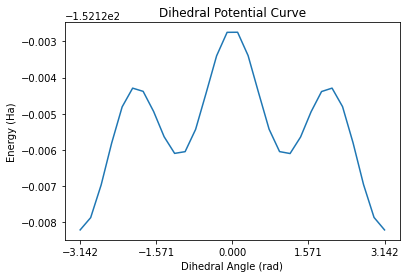

In [0]:
plt.plot(angles_list - np.pi, energy_list)
plt.xticks([-np.pi, -1/2*np.pi, 0, np.pi/2, np.pi])
plt.title('Dihedral Potential Curve')
plt.ylabel('Energy (Ha)')
plt.xlabel('Dihedral Angle (rad)')
plt.show()


Now it's your turn! Generate molecular energies for dihedral angle values of $\frac{\pi}{2}$, $\frac{\pi}{4}$, and $\frac{\pi}{6}$ radians.